## Section 6 Intra Application Experiments

* multiple clients running the same applications, with and without the techniques mentioned in section 4
* baseline (lego) is:
  * no adaptive/imu suppression
  * multiple workers: 1 worker per core  = 4 workers. 8 cores
* find the frames that are actually within active phase

In [1]:
from __future__ import print_function
import glob
import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize

from rmexp import dbutils, schema
from rmexp.schema import models

In [54]:
def get_trace_frames(app, trace_id):
    df = pd.read_sql(
        "select value from DataStat where app=%(app)s and trace=%(trace_id)s",
        schema.engine,
         params={'app': app, 'trace_id': trace_id}
    )
    datastat = json.loads(df['value'].iloc[0])
    total_frs = datastat['frames']
    return total_frs

def get_ss_df(app, trace_id):
    name = '{}-tr{}'.format(app, trace_id)
    df = pd.read_sql(
                "select * from SS where name like %(name)s",
                 schema.engine,
                 params={'name': name}
    )
    # SS's database index somehow started from 1, this is to fix it
    df['index'] = df['index'].astype('int32') - 1
    return df

def get_gt_active_df(app, trace_id):
    df = pd.read_sql(
                "select * from DutyCycleGT where name=%(app)s and trace=%(trace_id)s",
                 schema.engine,
                 params={'app': app, 'trace_id': trace_id}
    )
    df['index'] = df['index'].astype('int32')
    return df


def upload_sec6_exp_data(app, device_type='*', exp_name_regex='*.log'):
    # read in csv
    cvs_fps = glob.glob(
        '/home/junjuew/work/resource-management/data/sec6-res-util/{}/*/{}'.format(
            device_type, exp_name_regex))

    # upload data to db
    sess = dbutils.get_session()
    for cvs_fp in cvs_fps:
        data = pd.read_csv(cvs_fp, sep=',,', header=None, names=[
            'exp', 'fid', 'app', 'client_id', 'arrival_ts', 'finish_ts', 'end_ts', 'util', 'result'])
        exp_suffix = cvs_fp.split('/')[-3]
        app = data.iloc[0]['app']
        client_id = data.iloc[0]['client_id']
        dutycycle_df = get_gt_active_df(app, int(client_id))
        print('{}, app: {}, client_id: {}'.format(cvs_fp, app, client_id))
        if app == 'lego':
            was_active = False
            stage_detected = False
            for index, row in data.iterrows():
                cur_idx = int(row['fid'])
                # whether a frame should be active or not depends both on GT and state detection
                # state-change <----inactive-------> gt active <-----active---> state_change
                if not was_active:
                    if bool(int(dutycycle_df.iloc[cur_idx]['active'])):
                        stage_detected = False
                was_active = bool(int(dutycycle_df.iloc[cur_idx]['active']))
                cur_active = was_active and (not stage_detected)
                if was_active and '!!State Change!!' in row['result']:
                    stage_detected=True

                record = models.Sec6IntraApp(
                    name=row['exp']+exp_suffix, index=cur_idx, app=row['app'], client=row['client_id'],
                    arrival=row['arrival_ts'], finished=row['finish_ts'], reply=row['end_ts'], 
                    utility=row['util'], is_gt_active=cur_active, result=row['result'])
        if app == 'pingpong':
            for index, row in data.iterrows():
                cur_idx = int(row['fid'])
                record = models.Sec6IntraApp(
                        name=row['exp']+exp_suffix, index=cur_idx, app=row['app'], client=row['client_id'],
                        arrival=row['arrival_ts'], finished=row['finish_ts'], reply=row['end_ts'], 
                        utility=row['util'], 
                        is_gt_active=dutycycle_df.iloc[cur_idx]['active'], 
                        result=row['result'])
                sess.add(record)
        sess.commit()
    sess.close()
# TODO: the dutycyle and dutycycle + imu data is actually based on 1 frame
# rerun the experiments?
upload_sec6_exp_data(app='pingpong', device_type='baseline', exp_name_regex='*pingpong*.log')
# upload_sec6_exp_data(app='pingpong', device_type='dutycycleimu', exp_name_regex='*pingpong*.log')

/home/junjuew/work/resource-management/conda-env-rmexp/lib/python2.7/site-packages/ipykernel_launcher.py:42: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


/home/junjuew/work/resource-management/data/sec6-res-util/baseline/3/sec6-res-util-pingpong-c6m2.log, app: pingpong, client_id: 8
/home/junjuew/work/resource-management/data/sec6-res-util/baseline/3/sec6-res-util-pingpong-c4m2.log, app: pingpong, client_id: 8
/home/junjuew/work/resource-management/data/sec6-res-util/baseline/3/sec6-res-util-pingpong-c8m2.log, app: pingpong, client_id: 8
/home/junjuew/work/resource-management/data/sec6-res-util/baseline/3/sec6-res-util-pingpong-c2m2.log, app: pingpong, client_id: 8
/home/junjuew/work/resource-management/data/sec6-res-util/baseline/4/sec6-res-util-pingpong-c6m2.log, app: pingpong, client_id: 9
/home/junjuew/work/resource-management/data/sec6-res-util/baseline/4/sec6-res-util-pingpong-c4m2.log, app: pingpong, client_id: 9
/home/junjuew/work/resource-management/data/sec6-res-util/baseline/4/sec6-res-util-pingpong-c8m2.log, app: pingpong, client_id: 9
/home/junjuew/work/resource-management/data/sec6-res-util/baseline/4/sec6-res-util-pingpon

In [55]:
# find utility of an experiment
import pandas as pd

cpus = [2, 4, 6, 8]
def get_data(app, exp_types):
    data = {}
    for exp_type in exp_types:
        data[exp_type] = {}
        for cpu in cpus:
            exp = 'sec6-res-util-{}-c{}m2{}'.format(app, cpu, exp_type)
            df = pd.read_sql(
                "select * from Sec6IntraApp where name=%(name)s",
                 schema.engine,
                 params={'name': exp}
            )
            data[exp_type][cpu] = df
    return data
data=get_data('pingpong', exp_types = ['baseline', 'dutycycleimu'])

In [56]:
data['baseline'][2]

,id,name,index,app,client,arrival,finished,reply,utility,result,is_gt_active
0,109282,sec6-res-util-pingpong-c2m2baseline,7014,pingpong,8,107,192,157,9.999940e-01,Pingpong outside the table. Cannot initialize ...,1
1,109283,sec6-res-util-pingpong-c2m2baseline,7015,pingpong,8,76,155,127,1.000000e+00,Pingpong outside the table. Cannot initialize ...,1
2,109284,sec6-res-util-pingpong-c2m2baseline,7016,pingpong,8,133,223,187,9.954240e-01,Pingpong outside the table. Cannot initialize ...,1
3,109285,sec6-res-util-pingpong-c2m2baseline,7019,pingpong,8,123,211,175,9.990460e-01,Pingpong outside the table. Cannot initialize ...,1
4,109286,sec6-res-util-pingpong-c2m2baseline,7020,pingpong,8,178,281,245,3.181980e-01,Pingpong outside the table. Cannot initialize ...,1
5,109287,sec6-res-util-pingpong-c2m2baseline,7022,pingpong,8,208,315,279,3.014360e-02,Pingpong outside the table. Cannot initialize ...,0
6,109288,sec6-res-util-pingpong-c2m2baseline,7024,pingpong,8,169,240,204,9.792410e-01,Cannot find table. Detected table too small: 0...,0
7,109289,sec6-res-util-pingpong-c2m2baseline,7027,pingpong,8,136,163,143,1.000000e+00,Cannot find table. Table top line too short,0
8,109290,sec6-res-util-pingpong-c2m2baseline,7032,pingpong,8,103,120,84,1.000000e+00,Cannot find table.,0
9,109291,sec6-res-util-pingpong-c2m2baseline,7031,pingpong,8,122,143,110,1.000000e+00,Cannot find table. Detected table too small: 0...,0


<IPython.core.display.Javascript object>


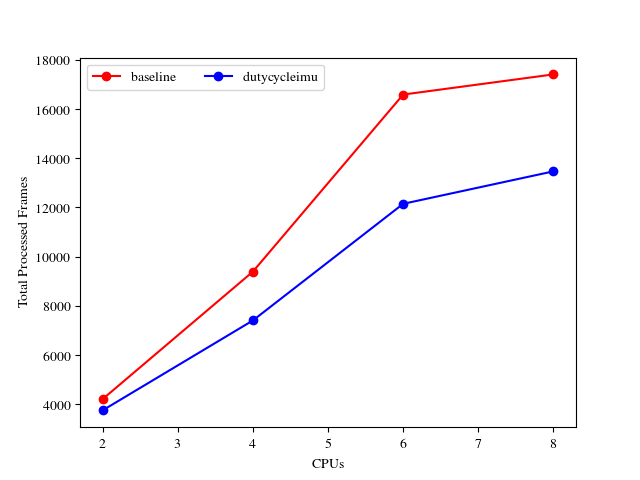

[4209, 9389, 16583, 17402]
[3754, 7406, 12145, 13464]


<IPython.core.display.Javascript object>


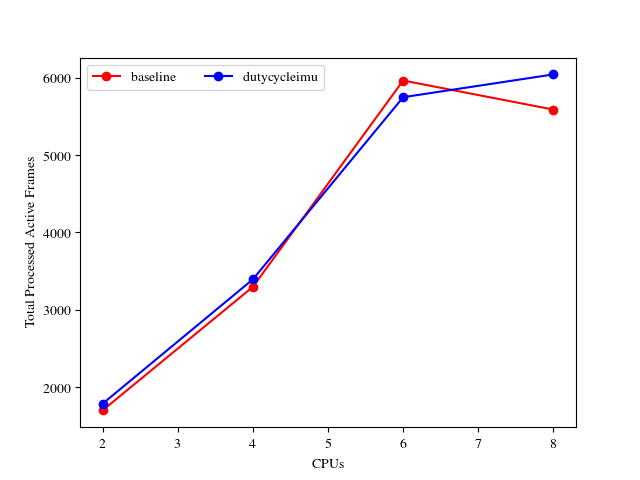

[1700, 3297, 5965, 5589]
[1786, 3394, 5749, 6044]


In [57]:
%matplotlib notebook
# plot resource cpu to utility
import matplotlib.pyplot as plt

def plot_data(data, exp_types):
    fmt = ['ro-', 'bo-', 'go-']
    plt.figure()
    for idx, exp_type in enumerate(exp_types):
        total_frs = map(lambda x: len(data[exp_type][x].index), cpus)
        print(total_frs)
        plt.plot(cpus, total_frs, fmt[idx], label=exp_type)
        plt.xlabel('CPUs')
        plt.ylabel('Total Processed Frames')
        plt.legend(ncol=2)
    #         plt.tight_layout()
    #         plt.savefig('fig-res-lat.pdf', bbox_inches='tight')

    # plot active frames
    plt.figure()
    for idx, exp_type in enumerate(exp_types):
        active_frs = map(lambda x: len(data[exp_type][x][data[exp_type][x]['is_gt_active']==1].index), cpus)
        print(active_frs)
        plt.plot(cpus, active_frs, fmt[idx], label=exp_type)
        plt.xlabel('CPUs')
        plt.ylabel('Total Processed Active Frames')
        plt.legend(ncol=2)
plot_data(data, exp_types=['baseline', 'dutycycleimu'])

In [29]:
%matplotlib notebook
# plot active frames
import matplotlib.pyplot as plt


ss_df = get_ss_df('lego')
import pdb; pdb.set_trace()
print(ss_df['name'].str.split("-", expand=True))
ss_df['trace'] = ss_df['name'].str.split("-", expand=True)['1']
print(ss_df)
# plt.figure()
# for idx, exp_type in enumerate(exp_types):
#     total_frs = map(lambda x: len(data[exp_type][x].index), cpus)
#     print(total_frs)
#     plt.plot(cpus, total_frs, fmt[idx], label=exp_type)
#     plt.xlabel('CPUs')
#     plt.ylabel('Total Processed Frames')
#     plt.legend(ncol=2)
#         plt.tight_layout()
#         plt.savefig('fig-res-lat.pdf', bbox_inches='tight')

--Return--
> <ipython-input-29-782e81b83da0>(14)<module>()->None
-> import pdb; pdb.set_trace()
(Pdb) ss-df
*** NameError: name 'ss' is not defined
(Pdb) ss_df
Empty DataFrame
Columns: [id, name, val, trace, index]
Index: []
(Pdb) c
Empty DataFrame
Columns: []
Index: []


KeyError: '1'

In [8]:
lego_active_gt = {
        'lego-tr1': [
            (230, 330),
            (430, 560),
            (730, 920),
            (1000, 1300),
            (1600, 1760),
            (2088, 2200),
            (2400, 2605),
        ],
        'lego-tr2': [
            (160, 390),
            (600, 850),
            (990, 1250),
            (1300, 1560),
            (1790, 2100),
            (2200, 2480),
            (2700, 2981),
            
        ],
        'lego-tr3': [
            (300, 500),
            (630, 860),
            (1090, 1290),
            (1360, 1660),
            (1800, 2000),
            (2200, 2480),
            (2660, 2858),
        ],
        'lego-tr4': [
            (200, 330),
            (560, 810),
            (1100, 1360),
            (1530, 1750),
            (1950, 2130),
            (2450, 2660),
            (2860, 3030),
            
        ],
        'lego-tr6': [
            (150, 330),
            (600, 800),
            (1400, 1560),
            (2200, 2440),
            (2700, 2900),
            (3240, 3500),
            (3850, 4083),
            
        ]
}

ikea_active_gt = {
        'ikea-tr1': [
            (6*30, 11*30),
            (23*30, 30*30),
            (39*30, 47*30),
            (71*30, 85*30),
            (92*30, 99*30),
            (122*30, 128*30),
            (137*30, 148*30),
            (162*30, 174*30),
        ],
        'ikea-tr3': [
            (6*30, 15*30),
            (30*30, 40*30),
            (52*30, 59*30),
            (84*30, 93*30),
            (102*30, 109*30),
            (131*30, 138*30),
            (144*30, 155*30),
            (167*30, 179*30),
        ],
        'ikea-tr4': [
            (5*30, 14*30),
            (27*30, 37*30),
            (43*30, 51*30),
            (66*30, 98*30),
            (104*30, 110*30),
            (133*30, 138*30),
            (144*30, 158*30),
            (168*30, 180*30),
        ],
        'ikea-tr5': [
            (6*30, 12*30),
            (30*30, 38*30),
            (45*30, 52*30),
            (76*30, 94*30),
            (108*30, 114*30),
            (134*30, 140*30),
            (144*30, 157*30),
            (166*30, 178*30),
        ],    
}

import pandas as pd
from rmexp.schema import models
from rmexp import schema, dbutils
import json
def upload_dutycycle_gt(active_gt):
    # upload gt data to db
    sess = dbutils.get_session()
    for trace, gts in active_gt.iteritems():
        app = trace.split('-')[0]
        trace_id = trace[-1]
        df = pd.read_sql(
            "select value from DataStat where app=%(app)s and trace=%(trace_id)s",
            schema.engine,
             params={'app': app, 'trace_id': trace_id}
        )
        datastat = json.loads(df['value'].iloc[0])
        total_frs = datastat['frames']
        print('total frames: {}'.format(total_frs))
        active = ['0'] * total_frs
        for (st, end) in gts:
            for i in range(st, end+1):
                active[i] = '1'
        for idx, is_active in enumerate(active):
            record = models.DutyCycleGT(
                name=app, trace=trace_id, index=idx, active=is_active
            )
            sess.add(record)
    sess.commit()
    sess.close()

# upload_dutycycle_gt(ikea_active_gt)

total frames: 5170


IndexError: list assignment index out of range